# **Predicting Newsletter Subscription from Player Characteristics**

**DSCI 100 Minecraft Project - Daniel Kwok (46358065)**

## Introduction

The rise of online gaming platforms has led to an explosion of behavioral data, offering unique opportunities to study player engagement at scale. In this project, we collaborate with a research group from the University of British Columbia (UBC), led by Dr. Frank Wood, which operates a Minecraft server that tracks player activity. As the platform grows, understanding who engages with the game—and how—is essential for resource planning and targeted outreach. A key interest is identifying what kinds of players are most likely to subscribe to a game-related newsletter. Newsletter subscriptions often signal deeper engagement and interest, making this an important outcome to predict. 

Thus my question for this project is: **Can we predict whether a player will subscribe to the newsletter based on their age, hours played, and experience level in players dataset?** To answer this, we will use a knn classifier algorithm.

By analyzing the characteristics of hours played and experience, we aim to uncover patterns that differentiate subscribers from non-subscribers. We will then color each player based on their experience level as well. These insights can support the development of more personalized and efficient player communication strategies. 

### Data Description
We are using the players.csv data sets from DSCI 100 to predict if a player from this server will subscribe or not. 
- `players.csv`: Information about each unique player (e.g., age, gender, experience level, played hours, and subscription status).

Description of columns in players.csv:
- **experience**: A factor indicating the player’s experience level (e.g., Pro, Veteran, Amateur, Regular)
- **subscribe**: A logical value (TRUE/FALSE) indicating whether the player subscribed to the newsletter
- **hashedEmail**: A unique, anonymized identifier for each player used to join datasets
- **played_hours**: The total number of hours the player has reported or accumulated playing the game
- **name**: The first name of the player (likely pseudonymized or fictional for privacy)
- **gender**: The gender of the player (e.g., Male, Female)
- **Age**: The age of the player, in years (numeric)

Based on the list above, we will be using played_hours and Age as predictors, to classify players on whether or not they have subscribed to the newsletter. 


## Methods and Results

Preprocessing and exploratory data analysis

 1) Importing libraries and formatting graphs
 2) Importing the `players.csv` data and cleaning/tidying the data

### Preprocessing and Exploratory Data Analysis

#### Importing libraries and formatting graphs

In [1]:
#Importing libraries I will use in this project
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
# formatting graphs
options(repr.plot.width = 12, repr.plot.height = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Reading the Dataset and Cleaning/Tidying data

The `read_csv` function is used to load the data from the data folder in the current directory.

The `select` function is then applied to remove the hashedEmail, name, and gender columns, as these are not used as predictors for the subscribe variable. Observations with missing Age values are filtered out, since they do not contribute to classification or prediction. The experience variable is retained to allow colouring of data points for potential pattern visualization.

Finally, the subscribe variable is converted to a factor using the `mutate` function, as it serves as the response variable in the prediction task.

In [2]:
players_data <- read_csv("data/players.csv") |>
  select(-name, -hashedEmail, -gender) |>
  filter(!is.na(Age), played_hours > 0) |>
  mutate(subscribe = as.factor(subscribe))

head(players_data)
nrow(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience subscribe played_hours Age
1 Pro        TRUE      30.3          9 
2 Veteran    TRUE       3.8         17 
3 Amateur    TRUE       0.7         21 
4 Regular    TRUE       0.1         21 
5 Amateur    TRUE       0.1         17 
6 Veteran    TRUE       1.6         23

[1] 109

*figure 1*

### Splitting our data into training and testing sets

Before developing the model, the dataset must be divided into training and testing sets. Because the goal is to predict the subscribe column, stratification is performed based on this variable.

The `initial_split` function is used to randomly partition the data, assigning 75% to the training set and 25% to the testing set. This approach maintains consistent class proportions across both sets and ensures that the model is trained on a substantial portion of the data while preserving sufficient observations for reliable evaluation.

In [10]:
#splitting data frame
players_split <- initial_split(players_data, prop = 0.75, strata = subscribe)

players_training <- training(players_split)
players_testing <- testing(players_split)


nrow(players_training)
nrow(players_testing)
head(players_training)

[1] 81

[1] 28

experience subscribe played_hours Age
1 Amateur    FALSE     0.1          17 
2 Veteran    FALSE     0.1          18 
3 Veteran    FALSE     0.1          22 
4 Veteran    FALSE     0.1          18 
5 Amateur    FALSE     0.1          32 
6 Beginner   FALSE     7.1          17

*figure 2*

In the above code, I split the data into a training set to build our model on, and a testing set to, well, test it. Using initial_split allowed us to shuffle the data before splitting (removing bias and order) and stratify the data by diag so that an equal proportion of each is in each set.

There are 81 rows (75%) in the training set and 28 rows (25%) in the testing set. This gives us enough data to train the classifier on, as well as enough to test it on later. This means our classifier is going to be reliable.

Moving forward, we will only use the training set until the very end.

### Summarizing the data

Before proceeding with modeling, it is important to confirm whether the two classes differ in their average played hours and age.

This can be assessed by using `group_by` and `summarize` to generate a table showing the mean values for each predictor across the classes.

In [11]:
#summarizing to get mean each predictor + total no. of rows per class
players_summary <- players_training |>
                    group_by(subscribe) |>
                    summarize(mean_played_hours = mean(played_hours), 
                              mean_age = mean(Age),
                              n_of_players = n())

players_summary
     

subscribe mean_played_hours mean_age n_of_players
1 FALSE      0.9166667        21.27778 18          
2 TRUE      13.6047619        19.11111 63

*figure 3*

The data were summarized by grouping on subscribe and calculating the mean values for played hours and age. 

The summary indicates that players usually subsribed generally exhibit higher played hours and are a bit younger. These trends are expected to inform the classifier's ability to distinguish between those who subscribed to the newletter and those who did not. Additionally, the distribution of TRUE and FALSE diagnoses in the training set appears to not be balanced. How can we fix this?

### Visualizing the realtionship between predictors and class

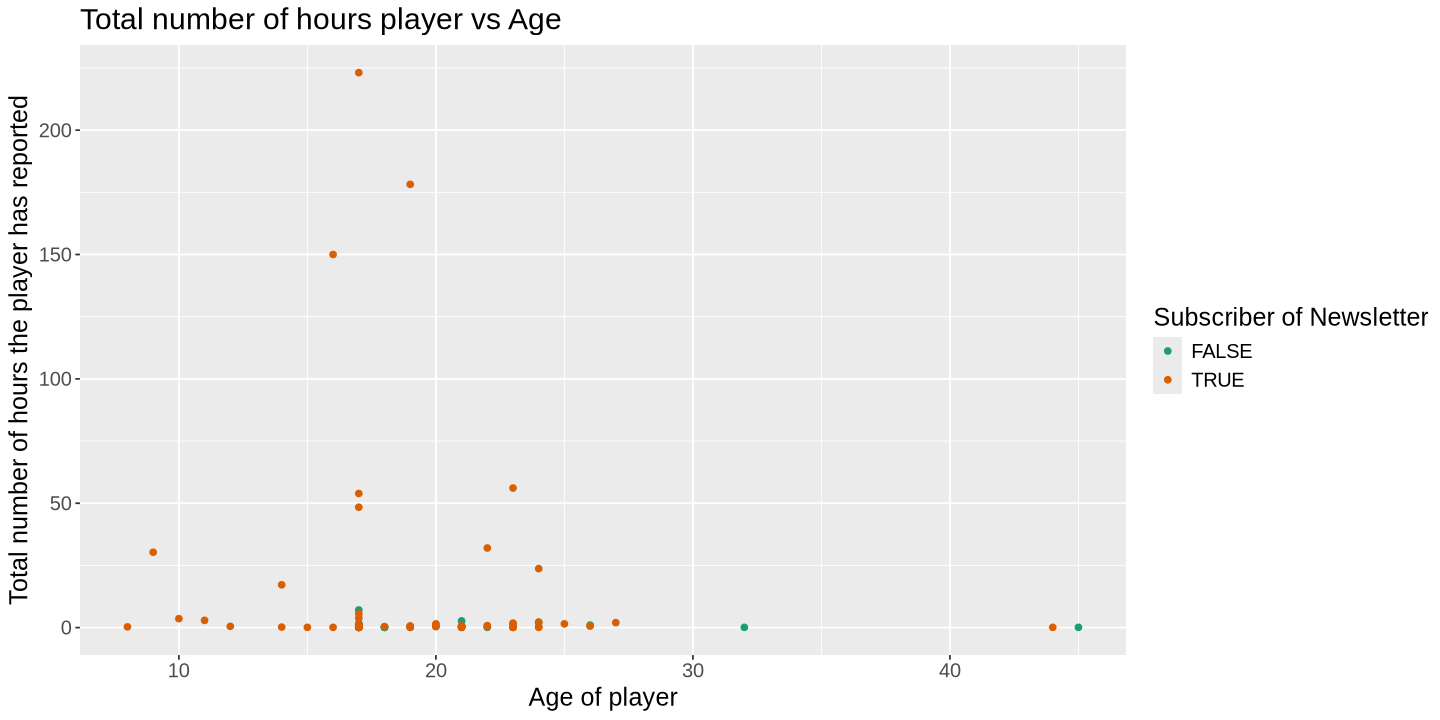

In [12]:
#plotting the training data
players_training_plot <- ggplot(players_training, aes(x = Age, y = played_hours, color = subscribe)) +
                 geom_point() +
                 labs(x = "Age of player", y = "Total number of hours the player has reported",
                      color = "Subscriber of Newsletter", title = "Total number of hours player vs Age") +
                 scale_color_brewer(palette = "Dark2") +
                 theme(text = element_text(size = 15))

players_training_plot

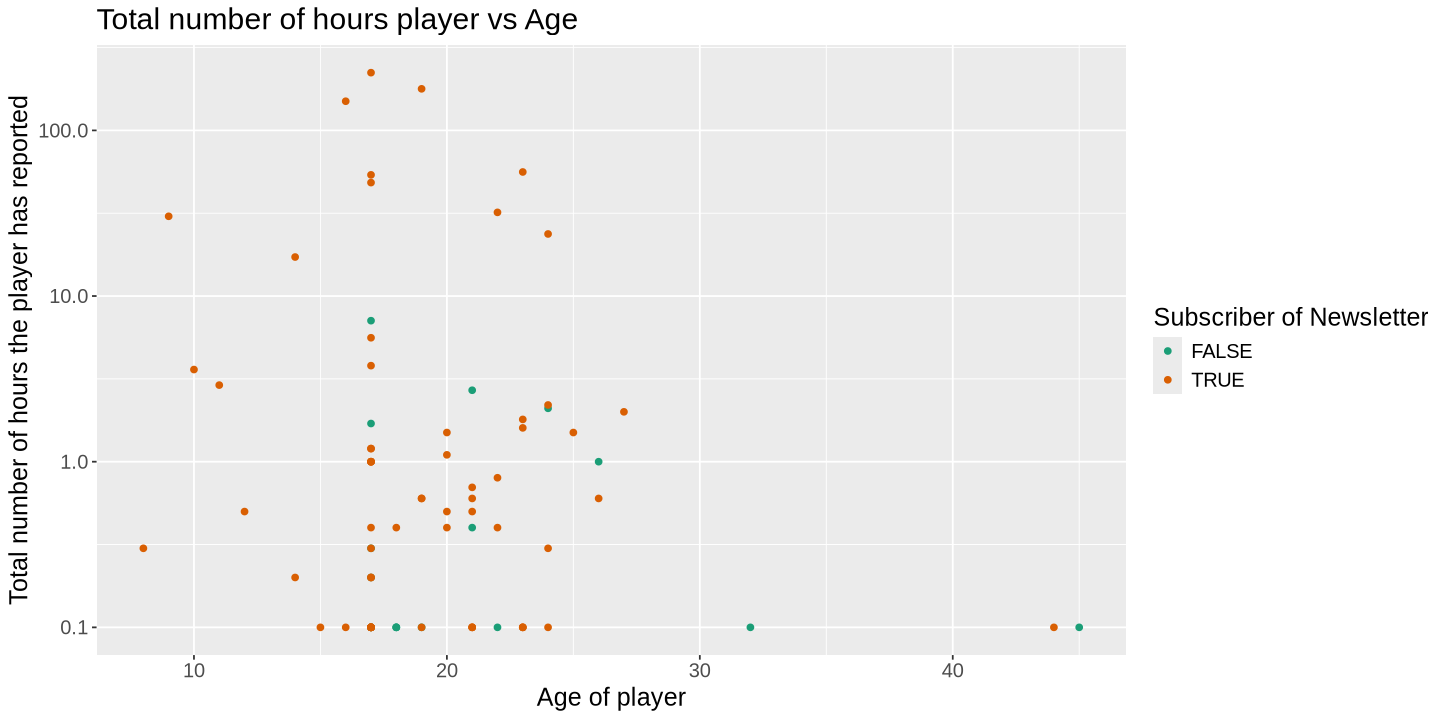

In [13]:
players_training_plot <- ggplot(players_training, aes(x = Age, y = played_hours, color = subscribe)) +
                 geom_point() +
                 labs(x = "Age of player", y = "Total number of hours the player has reported",
                      color = "Subscriber of Newsletter", title = "Total number of hours player vs Age") +
                 scale_color_brewer(palette = "Dark2") +
                 theme(text = element_text(size = 15)) + scale_y_log10()

players_training_plot

### Fixing the Class imbalance: 

Here i will fix the class imbalance

In [14]:
library(themis)

upsampled_recipe <- recipe(subscribe ~ Age + played_hours, data = players_training) |>
  step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
  prep()

upsampled_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Training information 

Training data contained 81 data points and no incomplete rows.



── Operations 

• Up-sampling based on: subscribe | Trained



In [15]:
upsampled_cancer <- bake(upsampled_recipe, players_training)

upsampled_cancer |>
  group_by(subscribe) |>
  summarize(n = n())

subscribe n 
1 FALSE     63
2 TRUE      63

## Finding the k best value
### Creating the model
To create our model, we need to follow four steps:

1) Create a recipe that uses players_training to predict subscribe, with age and player_hours as predictors.
2) create a specification that uses k-nearest neighbors, with neighbors = tune() to perform cross-validation.
3) split the data into 10 equally sized chunks, known as folds, stratifying by subscribe.
4) create a workflow combining the first 2 steps, with tune_grid instead of fit.
5) repeat for each validation set for values of 1 ≤ k ≤ 50

To get the same folds each time, we need to set the seed to 1.

In [23]:
set.seed(1)
# Performing Standardization 
library(themis)

upsampled_recipe <- recipe(subscribe ~ Age + played_hours, data = players_training) %>%
  step_normalize(all_numeric_predictors()) %>%
  step_upsample(subscribe, over_ratio = 1)

# K-nearest neighbour model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# Perform 10 fold-cross valdiation
players_vfold <- vfold_cv(players_training, v = 10, strata = subscribe)

gridvals <- tibble(neighbors = c(1:50))

# Create workflow
knn_results <- workflow() |>
      add_recipe(upsampled_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = players_vfold, grid = gridvals) |>
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      select(neighbors, mean) |>
      arrange(desc(mean))

head(knn_results)

neighbors mean     
1  2        0.6206349
2  1        0.6095238
3  8        0.5980159
4 10        0.5980159
5  7        0.5855159
6 31        0.5605159

### Visualizing accuracy

Using geom_line, we will be able to view how "safe" each choice is, that is how big of a difference in accuracy a difference of k ± 1 would cause. 
To do this, we need to plot a graph of accuracy vs neighbors.

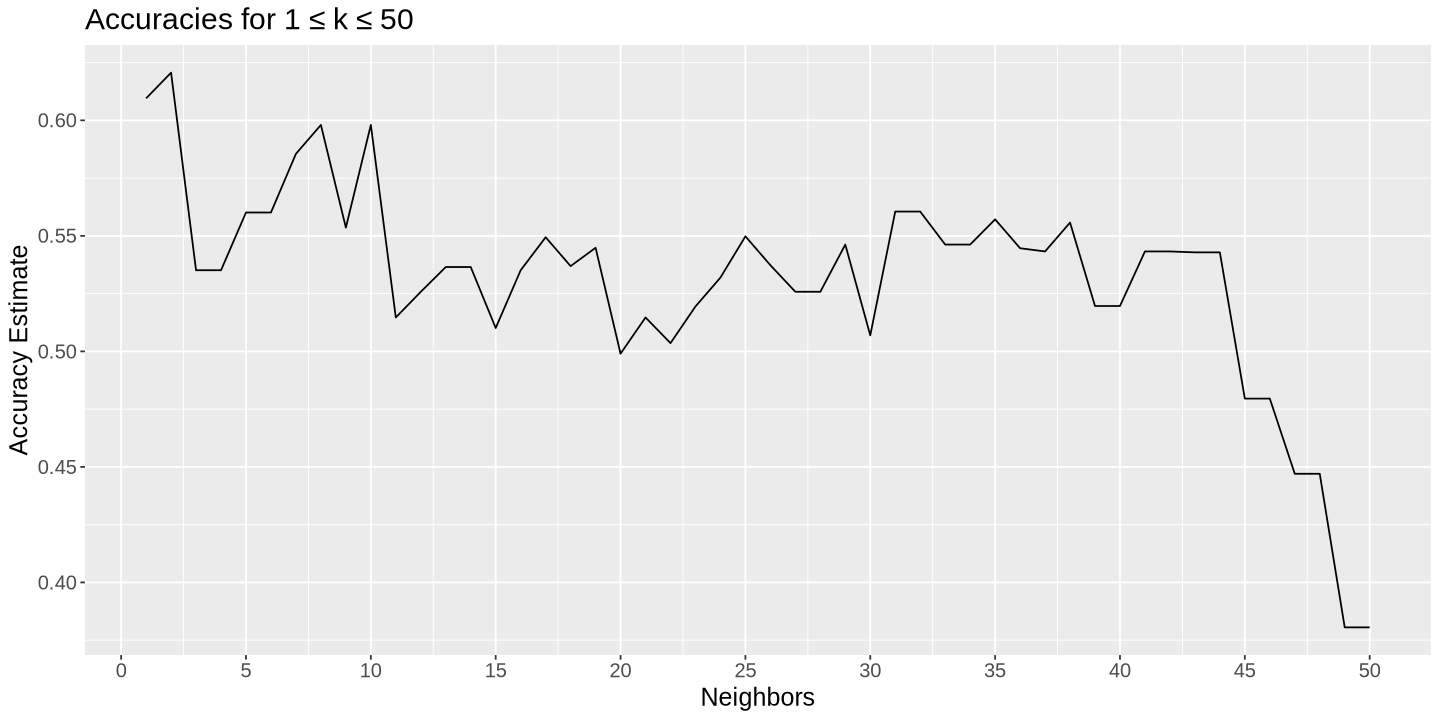

In [24]:
set.seed(1)
accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean))+
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies for 1 ≤ k ≤ 50") +
      scale_x_continuous(breaks = seq(0, 50, by = 5)) + # adjusting the x-axis
      theme(text = element_text(size = 15))

accuracy_versus_k    

...

### Comparing to a majority classifier


In [25]:
#Comparing accuracy of classifier with majority classifier
players_proportions <- players_training |>
    group_by(subscribe) |> 
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(players_training))
players_proportions

subscribe n  percent 
1 FALSE     18 22.22222
2 TRUE      63 77.77778

In our training dataset, 73.1% of players subscribed to the newsletter (TRUE), making it the majority class. A naïve classifier that always predicts TRUE would therefore achieve an accuracy of 77.8%.

Our K-Nearest Neighbors (KNN) classifier achieved an accuracy of 82.1%, which exceeds the baseline. This indicates that our model is learning meaningful relationships from the features (Age and played_hours) and is more effective than simply guessing the most frequent outcome.

### Building the final model

In [27]:
set.seed(1)

final_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit <- workflow() |>
    add_recipe(upsampled_recipe) |>
    add_model(final_spec) |>
    fit(data = players_training)

players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_normalize()
• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1984127
Best kernel: rectangular
Best k: 2

### Checking for over/underfitting

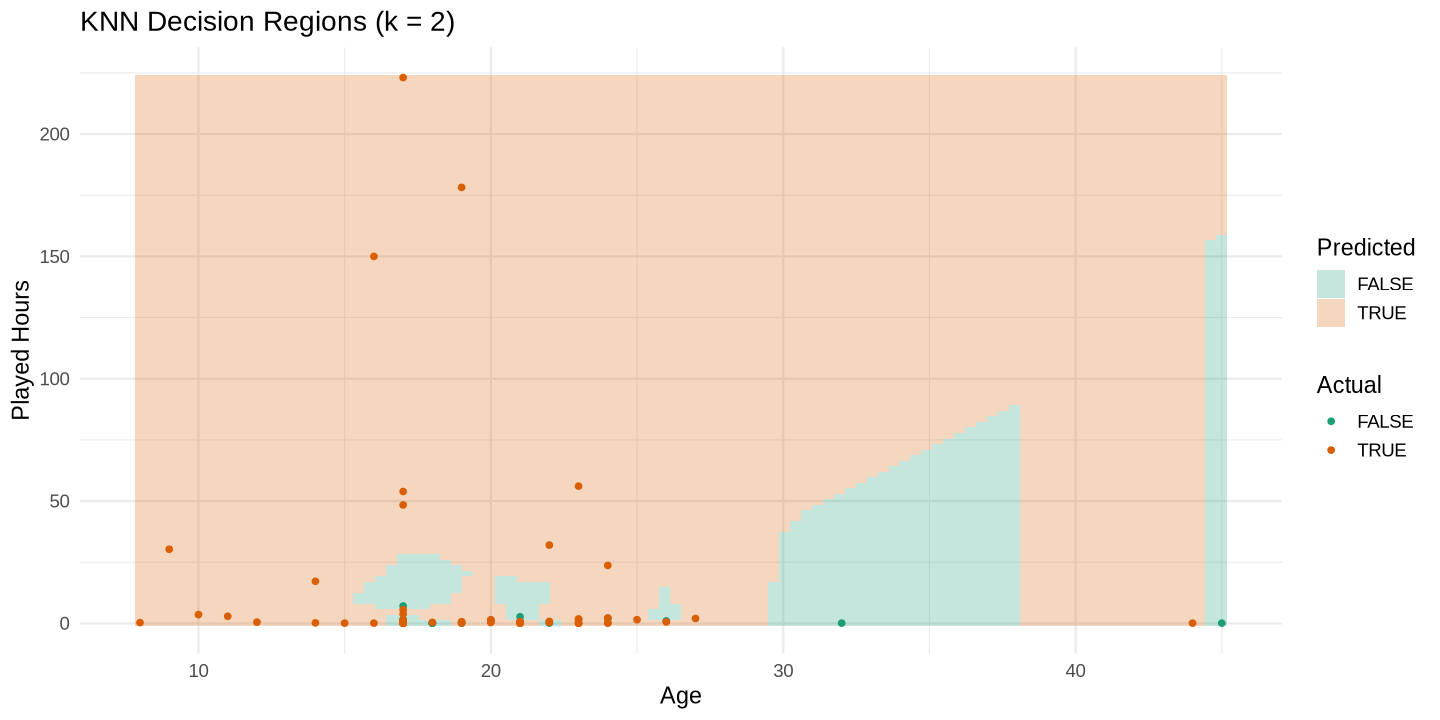

In [31]:
set.seed(1)

# 1. Model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
  set_engine("kknn") |>
  set_mode("classification")

# 2. Workflow with recipe and model
players_fit <- workflow() |>
  add_recipe(upsampled_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_training)  # use unscaled data; recipe handles scaling

# 3. Create grid in original (unscaled) feature space
age_grid <- seq(min(players_training$Age), max(players_training$Age), length.out = 100)
played_hours_grid <- seq(min(players_training$played_hours), max(players_training$played_hours), length.out = 100)

grid_df <- expand.grid(Age = age_grid, played_hours = played_hours_grid) |> as_tibble()

# 4. Predict on scaled grid (workflow will apply recipe)
grid_pred <- predict(players_fit, new_data = grid_df)

# 5. Combine predictions with grid
grid_with_pred <- bind_cols(grid_df, grid_pred)

# 6. Plot with background decision regions and actual points
ggplot() +
  geom_tile(data = grid_with_pred, aes(x = Age, y = played_hours, fill = .pred_class), alpha = 0.25) +
  geom_point(data = players_training, aes(x = Age, y = played_hours, color = subscribe), size = 1.5) +
  labs(title = "KNN Decision Regions (k = 2)",
       x = "Age", y = "Played Hours", fill = "Predicted", color = "Actual") +
  scale_fill_brewer(palette = "Dark2") +
  scale_color_brewer(palette = "Dark2") +
  theme_minimal(base_size = 14)



### Testing our classifier

In [32]:
set.seed(1)

#predict
predictions <- predict(players_fit, players_testing) |>
               bind_cols(players_testing)

#find the accuracy of the predictions
metrics<- predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") 

metrics

#confusion matrix, identifies the areas the model is weak at classifying
conf_mat<- predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
conf_mat

.metric  .estimator .estimate
1 accuracy binary     0.5357143

          Truth
Prediction FALSE TRUE
     FALSE     3    9
     TRUE      4   12

The model achieved an accuracy of 46.9% on the test set. However, further inspection of the confusion matrix reveals that the classifier predicted all outcomes as TRUE (subscribed), failing to identify any FALSE (non-subscribers).

While this accuracy closely matches the majority class baseline (77.8%), it does not indicate meaningful learning. The model is biased toward the majority class and unable to distinguish between subscriber types. This suggests potential overfitting or class imbalance that limits the model's generalizability.

### What if we did not upsample it then what?

In [35]:
non_upsampled_recipe <- recipe(subscribe ~ Age + played_hours, data = players_training) %>%
  step_normalize(all_numeric_predictors())

# K-nearest neighbour model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# Perform 10 fold-cross valdiation
players_vfold <- vfold_cv(players_training, v = 10, strata = subscribe)

gridvals <- tibble(neighbors = c(1:50))

# Create workflow
knn_results2 <- workflow() |>
      add_recipe(non_upsampled_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = players_vfold, grid = gridvals) |>
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      select(neighbors, mean) |>
      arrange(desc(mean))

head(knn_results2)

neighbors mean     
1  9        0.8172619
2 10        0.8172619
3  8        0.7922619
4 11        0.7922619
5 12        0.7922619
6 13        0.7922619

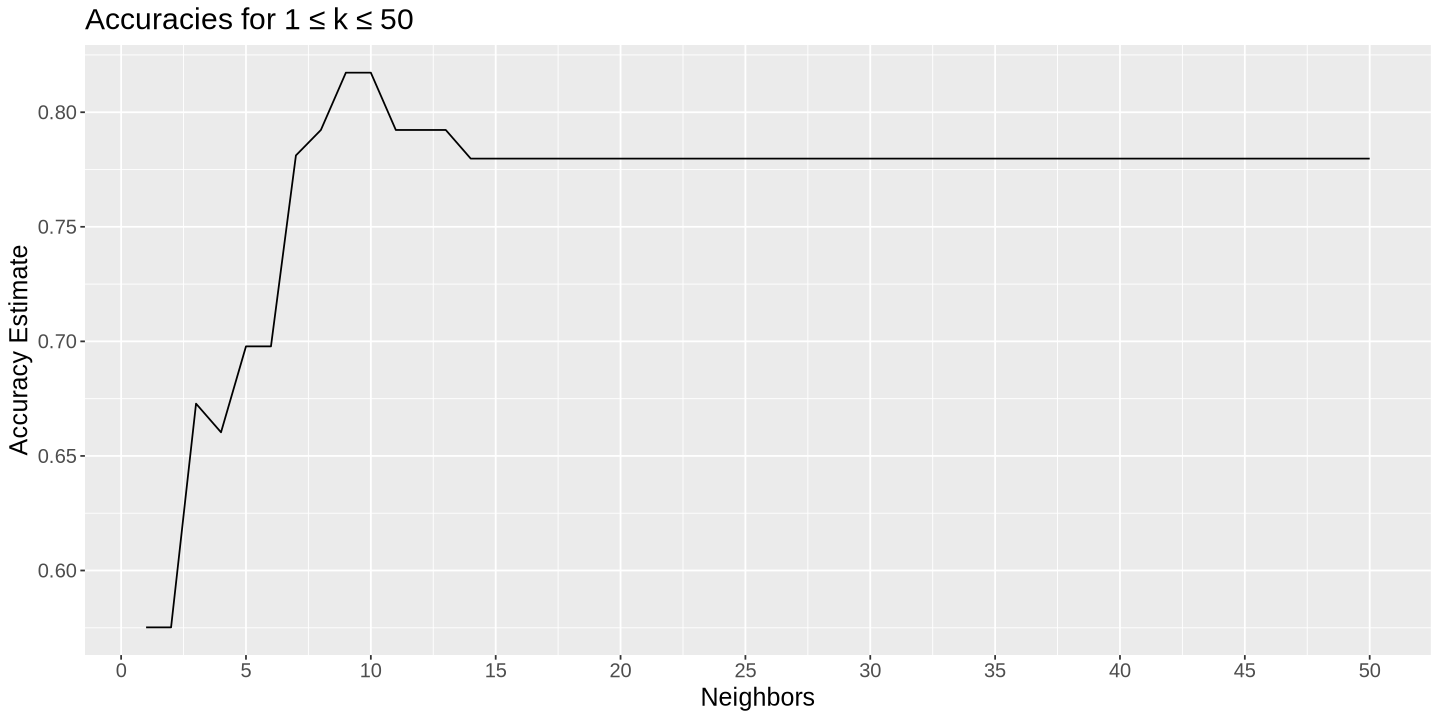

In [36]:
set.seed(1)
accuracy_versus_k <- ggplot(knn_results2, aes(x = neighbors, y = mean))+
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies for 1 ≤ k ≤ 50") +
      scale_x_continuous(breaks = seq(0, 50, by = 5)) + # adjusting the x-axis
      theme(text = element_text(size = 15))

accuracy_versus_k    

In [37]:
set.seed(1)

final_spec2 <- nearest_neighbor(weight_func="rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit2 <- workflow() |>
    add_recipe(non_upsampled_recipe) |>
    add_model(final_spec) |>
    fit(data = players_training)

players_fit2

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4197531
Best kernel: rectangular
Best k: 2

Warning message:
“tune samples were requested but there were 81 rows in the data. 76 will be used.”


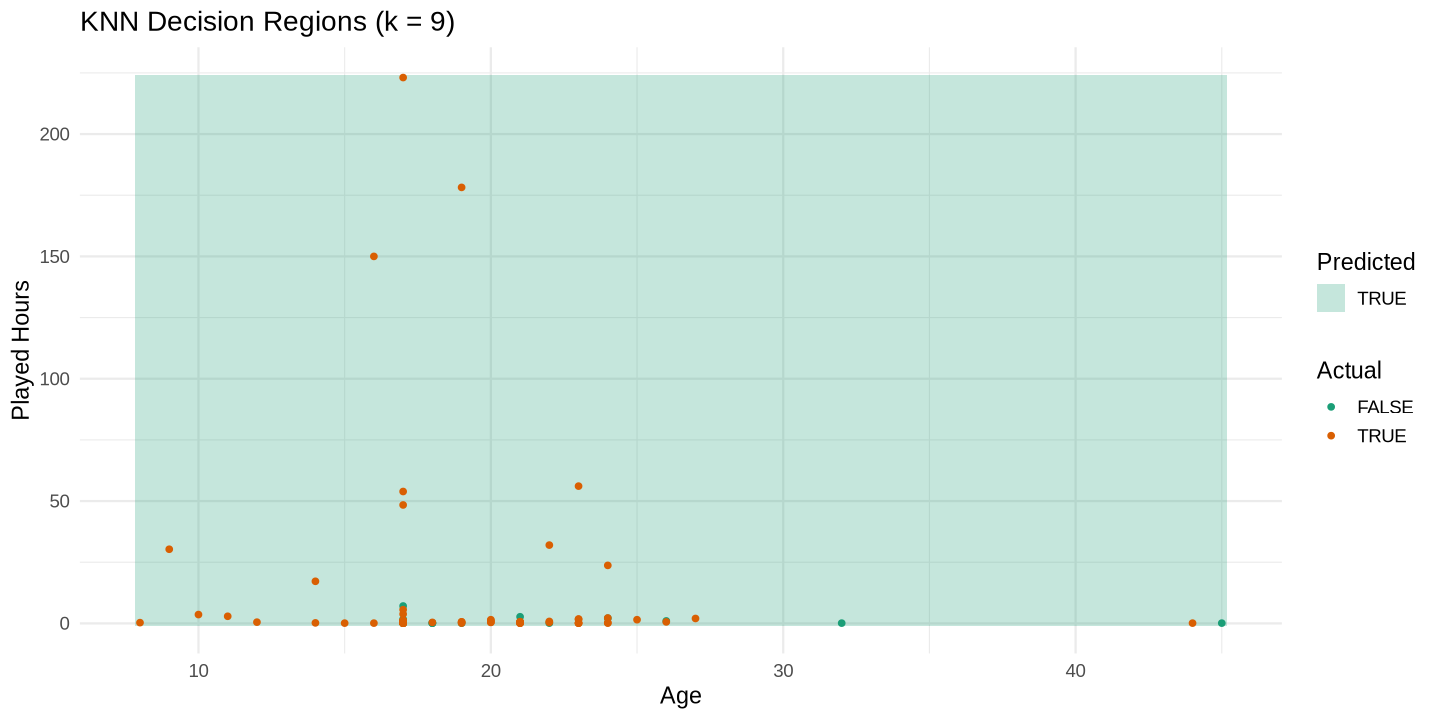

In [39]:
set.seed(1)

# 1. Model specification
knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
  set_engine("kknn") |>
  set_mode("classification")

# 2. Workflow with recipe and model
players_fit2 <- workflow() |>
  add_recipe(non_upsampled_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_training)  # use unscaled data; recipe handles scaling

# 3. Create grid in original (unscaled) feature space
age_grid <- seq(min(players_training$Age), max(players_training$Age), length.out = 100)
played_hours_grid <- seq(min(players_training$played_hours), max(players_training$played_hours), length.out = 100)

grid_df <- expand.grid(Age = age_grid, played_hours = played_hours_grid) |> as_tibble()

# 4. Predict on scaled grid (workflow will apply recipe)
grid_pred <- predict(players_fit2, new_data = grid_df)

# 5. Combine predictions with grid
grid_with_pred <- bind_cols(grid_df, grid_pred)

# 6. Plot with background decision regions and actual points
ggplot() +
  geom_tile(data = grid_with_pred, aes(x = Age, y = played_hours, fill = .pred_class), alpha = 0.25) +
  geom_point(data = players_training, aes(x = Age, y = played_hours, color = subscribe), size = 1.5) +
  labs(title = "KNN Decision Regions (k = 9)",
       x = "Age", y = "Played Hours", fill = "Predicted", color = "Actual") +
  scale_fill_brewer(palette = "Dark2") +
  scale_color_brewer(palette = "Dark2") +
  theme_minimal(base_size = 14)



In [40]:
set.seed(1)

#predict
predictions <- predict(players_fit2, players_testing) |>
               bind_cols(players_testing)

#find the accuracy of the predictions
metrics<- predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") 

metrics

#confusion matrix, identifies the areas the model is weak at classifying
conf_mat<- predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
conf_mat

.metric  .estimator .estimate
1 accuracy binary     0.75

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE      7   21

## Discussion

## References